In [ ]:
#|default_exp mps

# Set env variables to avoid warnings during multiprocessing

In [ ]:
#|export 
import torch, os
import torch.backends.mps # for pyright
import fastcore.all as fc
# [W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel 
# work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
# Alternative if we won't find a way to use mutliprocessing with MPS:
if torch.backends.mps.is_available():
    if (k:='OMP_NUM_THREADS') not in os.environ: os.environ[k]='1'
    if (k:='PYTORCH_ENABLE_MPS_FALLBACK') not in os.environ: os.environ[k]='1'

In [ ]:
#|export
from miniai.init import init_weights as orig_init_weights
from miniai.activations import set_seed
from miniai.learner import Callback


## MPS randn/normal don't use pytorch seeds

Initially randn was always returning the same 'random' vector on mps, this changed with [patch](https://github.com/pytorch/pytorch/pull/78010/commits) but it does not use seed set with troch.manual_seed()

So on mps we move the layers to cpu before init and then back to mps

In [ ]:
set_seed(42); print(torch.randn(10))
set_seed(42); print(torch.randn(10))
if torch.backends.mps.is_available():
    set_seed(42); print(torch.randn(10, device='mps'))
    set_seed(42); print(torch.randn(10, device='mps'))

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])
tensor([ 3.7750,  0.5150,  0.4238, -1.0694, -2.4454,  1.1967, -1.9430,  0.3254,
        -0.3740, -0.3755], device='mps:0')
tensor([-2.2156, -0.9671,  0.2496,  0.7735,  0.9785,  0.7212,  2.0625,  2.2164,
        -2.3274,  0.0332], device='mps:0')


/opt/homebrew/Caskroom/mambaforge/base/envs/miniai/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [ ]:
??init_weights

Signature: init_weights(m, leaky=0.0)
Docstring: <no docstring>
Source:   
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)
File:      ~/Workspace/fastai/part2/course22p2/miniai/init.py
Type:      function


In [ ]:
c = torch.nn.Conv1d(10,10, 2)
c.to('mps') 
set_seed(42)
orig_init_weights(c)
print(c.weight.max(), 'seed 42')
set_seed(42)
orig_init_weights(c)
print(c.weight.max(), 'seed 42')

tensor(1.0626, device='mps:0', grad_fn=<MaxBackward1>) seed 42
tensor(0.8696, device='mps:0', grad_fn=<MaxBackward1>) seed 42


In [ ]:
#| export
def init_weights(m, *args, **kwargs):
    devs = [p.device for p in m.parameters()]
    try:
        m.to('cpu')
        return orig_init_weights(m, *args, **kwargs)
    finally:
        for p,d in zip(m.parameters(), devs): m.to(d)

# This if cannot be in front of init_weights as then it nbdev won't put it to __all__
if not torch.backends.mps.is_available(): init_weights = orig_init_weights # type: ignore 

In [ ]:
set_seed(42)
init_weights(c)
print(c.weight.max(), 'seed 42')
set_seed(42)
init_weights(c)
print(c.weight.max(), 'seed 42')

tensor(0.7014, device='mps:0', grad_fn=<MaxBackward1>) seed 42
tensor(0.7014, device='mps:0', grad_fn=<MaxBackward1>) seed 42


## Reseed CB
This callback facilitate using different seeds while still keeping the training reproducable by reporting the seed on each use.

In [ ]:
#| export
class ReseedCB(Callback):
    order = 0
    def __init__(self): self.gen, self.new_seed = torch.Generator(), None
    def before_fit(self, learn): 
        self.set_seed(self.new_seed)
        print('Using seed', self.new_seed)
    def set_seed(self, seed=None): 
        if seed is None: 
            self.new_seed = torch.randint(2**31, [1], generator=self.gen).item()
            print(f"New seed: {self.new_seed}")
        else:
            self.new_seed = seed
        set_seed(self.new_seed)
        return self.new_seed
    def previous(self): self.set_seed(self.new_seed)
    def new(self): self.set_seed()

In [ ]:
reseed=ReseedCB()

Seed is set twice, on pervious|new|set_seed and before every seed

In [ ]:
reseed.before_fit(None)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 205811062
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.previous()
print(torch.randn(10)) # useful during init
reseed.before_fit(None)
print(torch.randn(10))

tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.set_seed(42)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])
Using seed 42
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])


In [ ]:
reseed.new()
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])
Using seed 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])


## Speed of Training

Unfortunately the multiprocessing is a bit slower on MPS as the main process has to share the number of OMP Threads (the value cannot be changed after fork). So to avoid warnings it is set to 1. Which makes the dataloader a bit slower.  To workaround this i've added cache_dataset_as_dict

It improves the performance 4x for large batch sizes from:
- 16 sec per fit(5)

to:

- 5 sec initial loading time
- 3.6 sec per fit(5)

In [ ]:
#| export
# if spawn is not possible, we can cache the entire dataset in memory after transformations
def _with_features(ds):
    setattr((l:=fc.L(ds)), 'features', ds.features)
    return l 
def cache_dataset_as_dict(dd): return {dsn: _with_features(ds) for dsn,ds in dd.items()}

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import get_model

In [ ]:
bs = 1024*16
xmean, xstd = 0.28, 0.35
name = "fashion_mnist"
def to_tensor_tfm(b, mean, std, xl='image'): 
    b[xl] = [(TF.to_tensor(o)-mean)/std for o in b[xl]]
    return b

dsd = load_dataset(name)
tds = dsd.with_transform(partial(to_tensor_tfm, mean=xmean, std=xstd))
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus, )

Found cached dataset fashion_mnist (/Users/pczapla/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
set_seed(42)
learn = TrainLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.350,2.060,0,train
0.577,1.224,0,eval
0.656,0.983,1,train
0.730,0.773,1,eval
0.732,0.760,2,train
0.752,0.659,2,eval
0.770,0.620,3,train
0.778,0.611,3,eval
0.792,0.568,4,train
0.795,0.553,4,eval


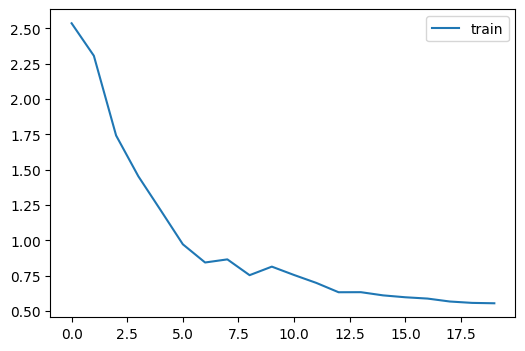

15.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
learn.fit(5)

In [ ]:
tds_cached = cache_dataset_as_dict(tds)

In [ ]:
set_seed(42)
dls_cached = DataLoaders.from_dd(tds_cached, bs, num_workers=0)
learn = TrainLearner(get_model().apply(iw), dls_cached, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.350,2.060,0,train
0.577,1.224,0,eval
0.656,0.983,1,train
0.730,0.773,1,eval
0.732,0.760,2,train
0.752,0.659,2,eval
0.770,0.620,3,train
0.778,0.611,3,eval
0.792,0.568,4,train
0.795,0.553,4,eval


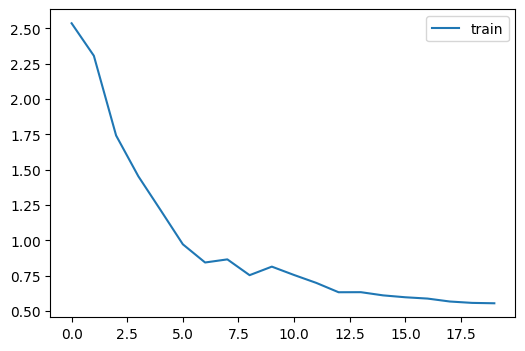

3.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
learn.fit(5)

## Export

In [ ]:
import nbdev; nbdev.nbdev_export()